<a href="https://colab.research.google.com/github/abhishekpal7630/4th-Year-Project/blob/main/Copy_of_automatic_mask_generator_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-nbt7uppb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-nbt7uppb
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2023-08-23 18:29:43--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 503 Backend is unhealthy
2023-08-23 18:29:43 ERROR 503: Backend is unhealt

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread('/content/images/test.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

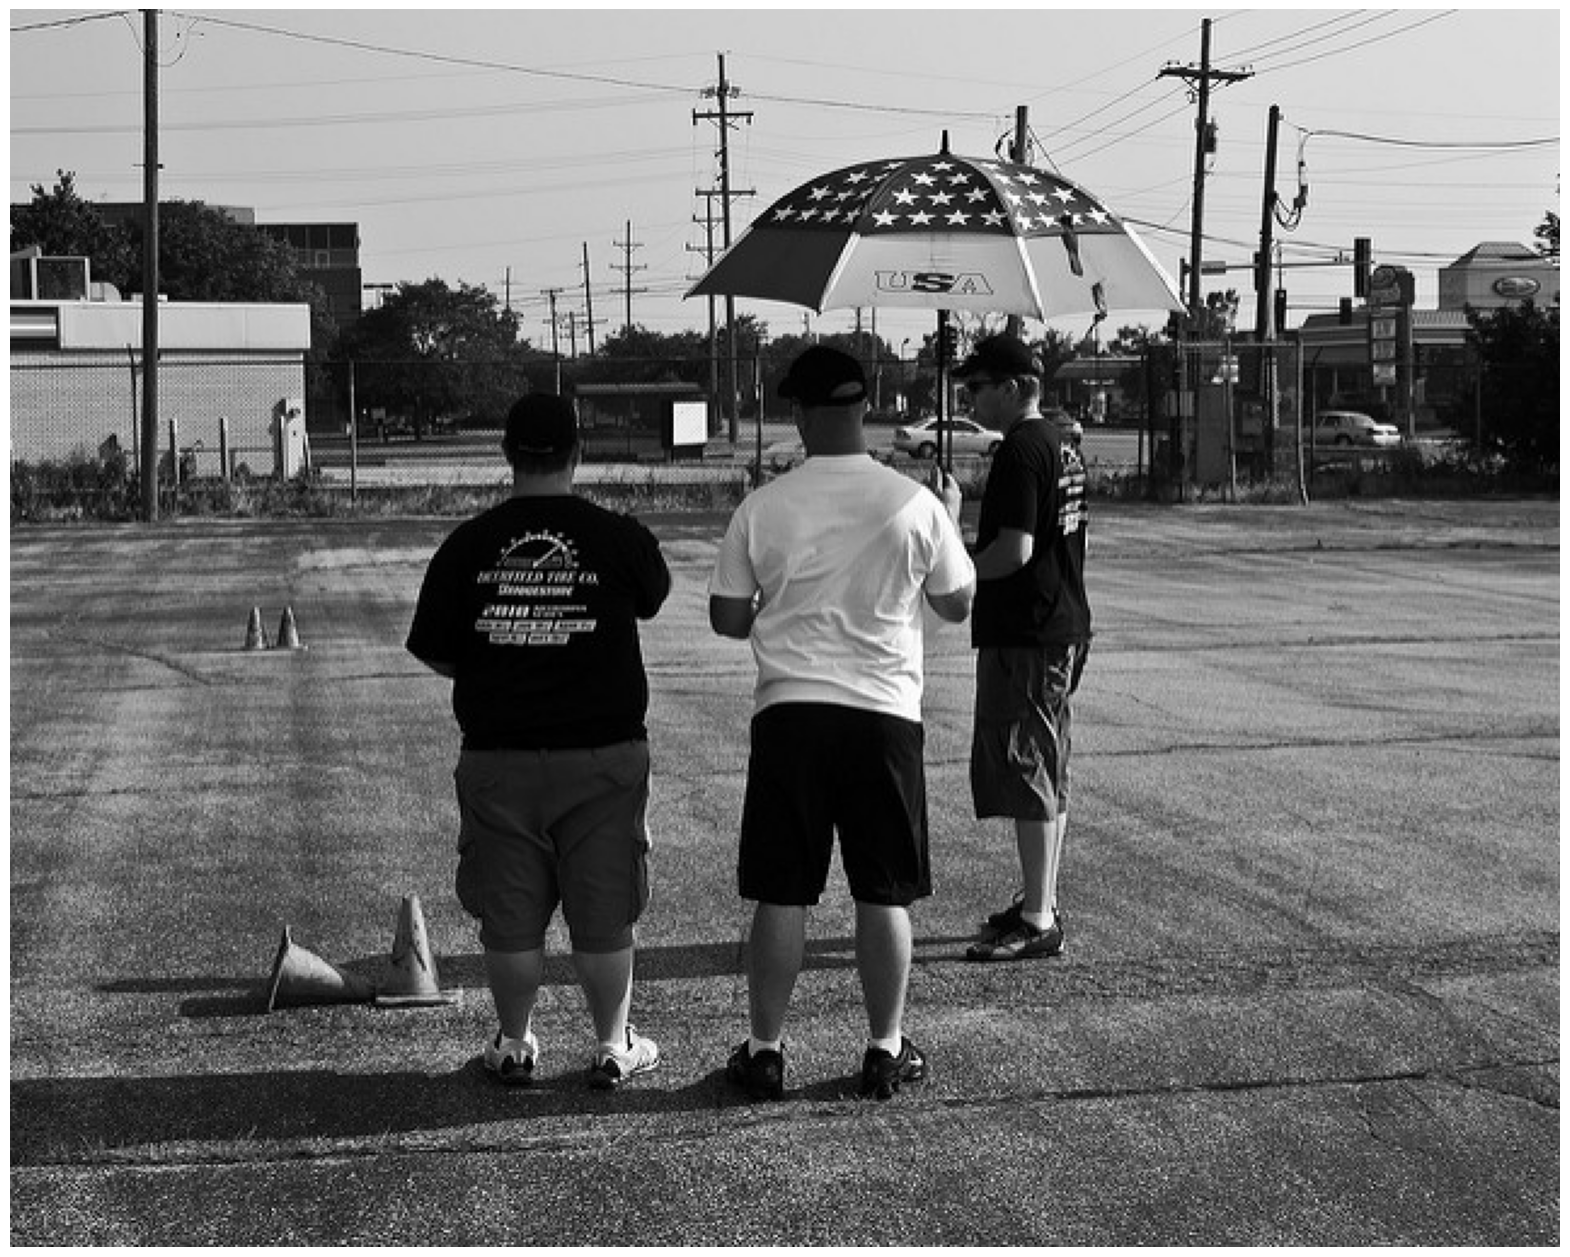

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[1].keys())

104
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

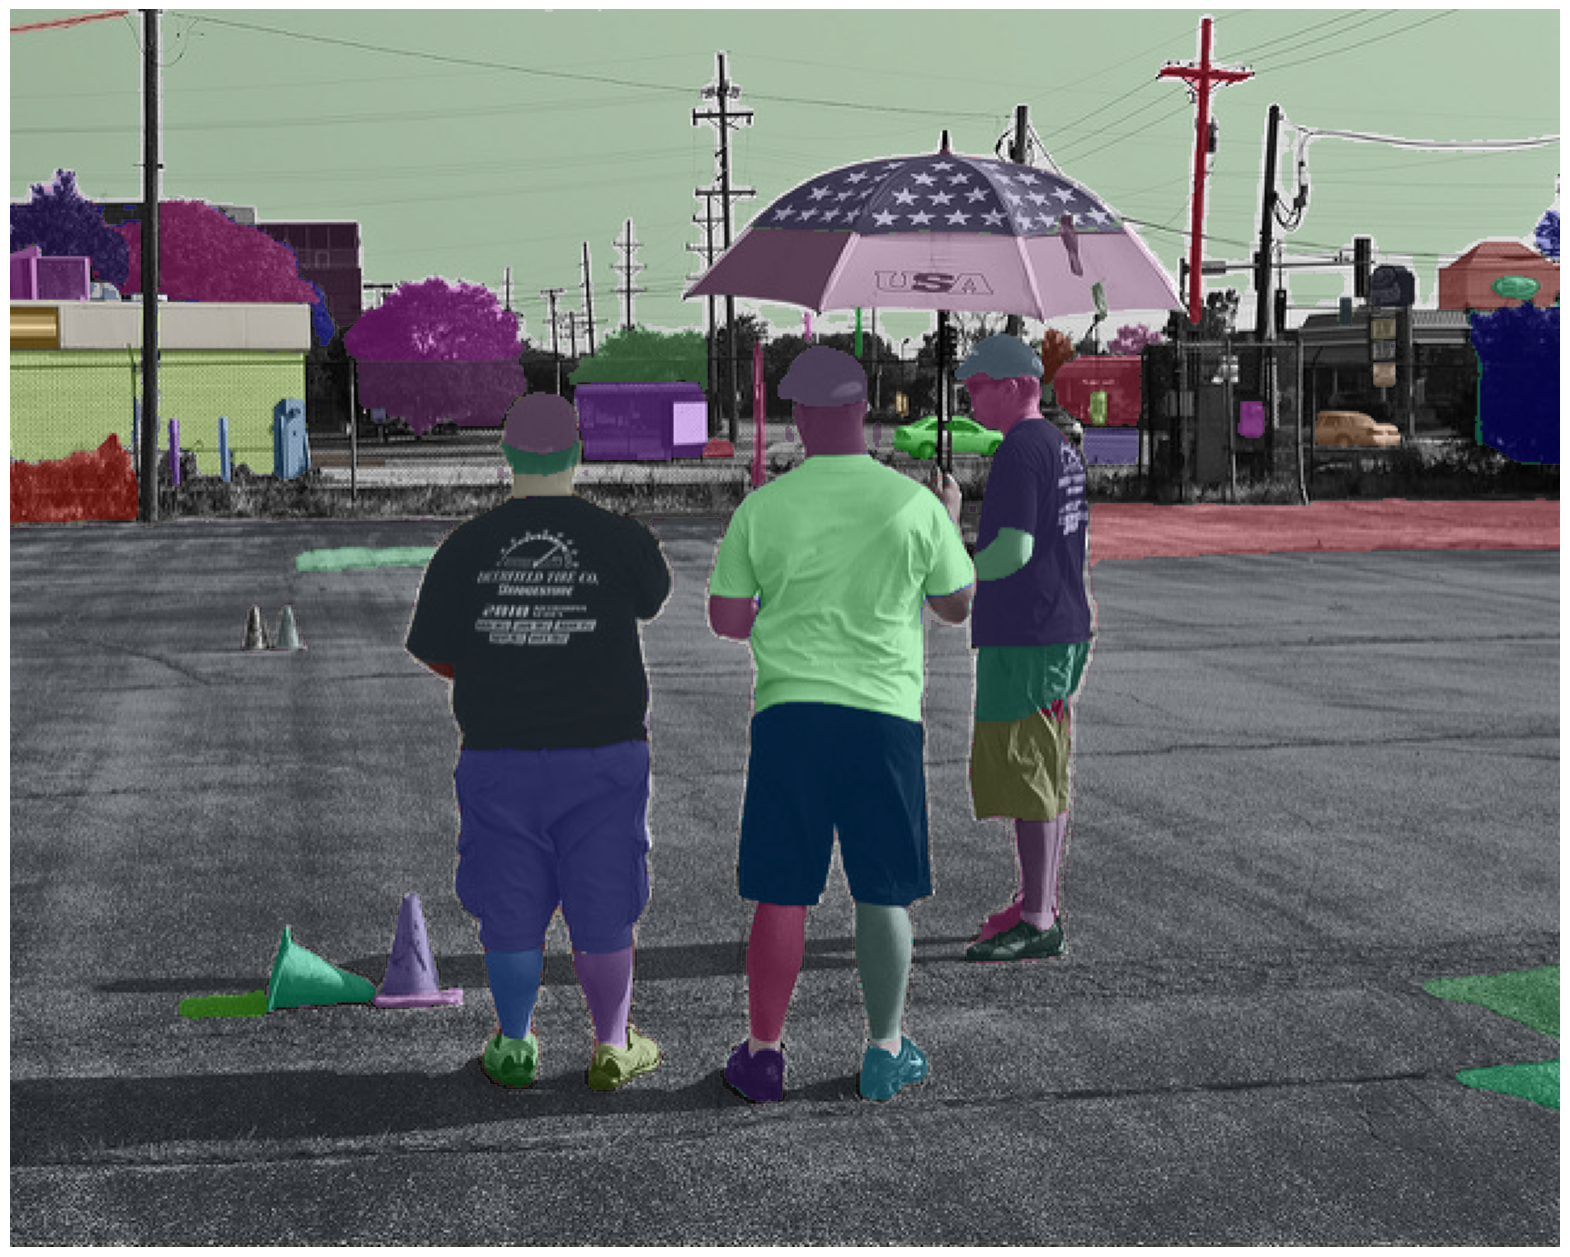

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

179

THE FOLLOWING CODES ARE FOR CELL SEGMENTATION OF 2018 KAGGLE BOWL DATASET DEVELOPED BY CARPENTER LAB OF BROAD INSTITUTE OF HARVARD AND MIT.

In [ ]:
!git clone https://github.com/lopuhin/kaggle-dsbowl-2018-dataset-fixes

Cloning into 'kaggle-dsbowl-2018-dataset-fixes'...
remote: Enumerating objects: 33416, done.
remote: Total 33416 (delta 0), reused 0 (delta 0), pack-reused 33416
Receiving objects: 100% (33416/33416), 70.88 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (11703/11703), done.
Updating files: 100% (29652/29652), done.


In [ ]:
import pandas as pd
import sys

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
# model_type = "vit_b"
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# mask_generator = SamAutomaticMaskGenerator(sam)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

No. of images =  664
0 /content/kaggle-dsbowl-2018-dataset-fixes/stage1_train/777f7c4269279951ae05b56e806745e613297d411d048c0bce8964afd7d71a4b/images/777f7c4269279951ae05b56e806745e613297d411d048c0bce8964afd7d71a4b.png
No. of detected cells =  43


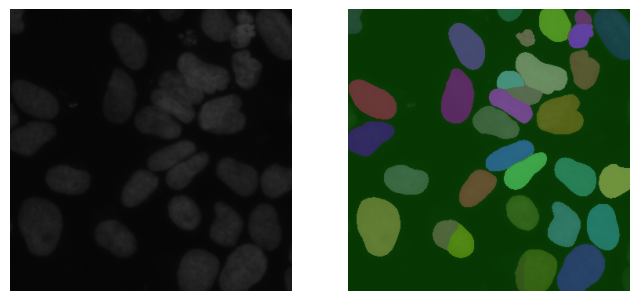

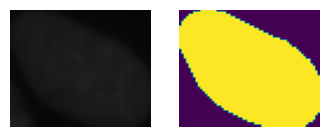

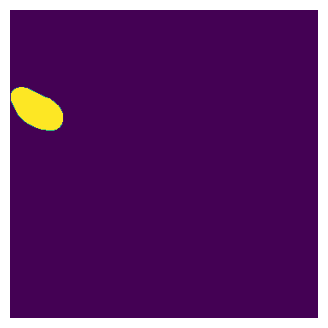

---
image no.  0
Area:  2088
predicted_iou:  1.001526117324829
stability_score:  0.9895238280296326
-----------------------------------------------------------------


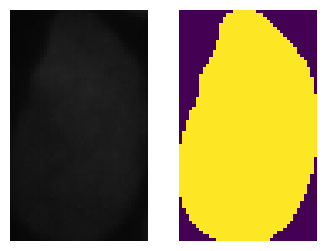

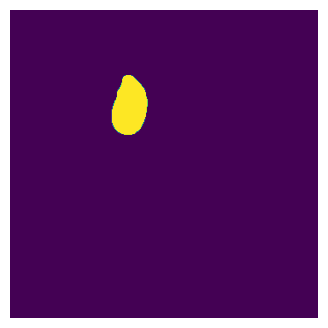

---
image no.  1
Area:  2203
predicted_iou:  0.9983100891113281
stability_score:  0.988261878490448
-----------------------------------------------------------------


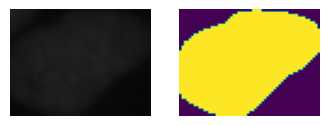

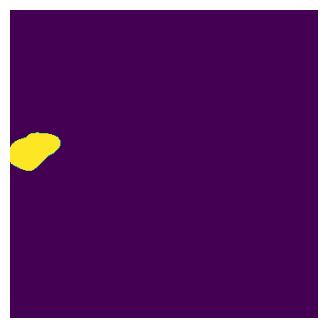

---
image no.  2
Area:  1836
predicted_iou:  0.9981059432029724
stability_score:  0.9837574362754822
-----------------------------------------------------------------


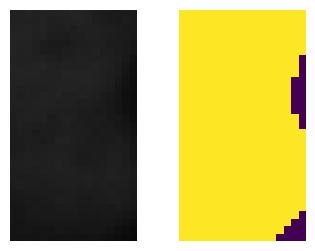

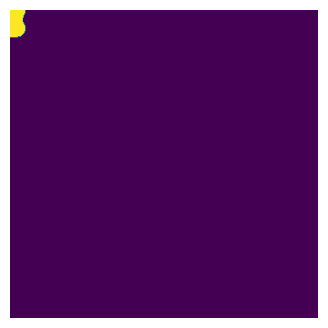

---
image no.  3
Area:  522
predicted_iou:  0.996536135673523
stability_score:  0.9885495901107788
-----------------------------------------------------------------


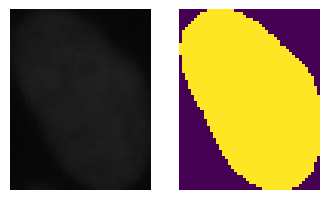

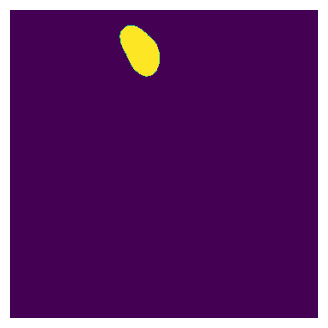

---
image no.  4
Area:  1908
predicted_iou:  0.9935038685798645
stability_score:  0.9848800897598267
-----------------------------------------------------------------


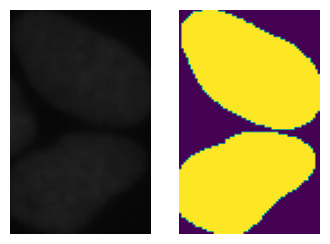

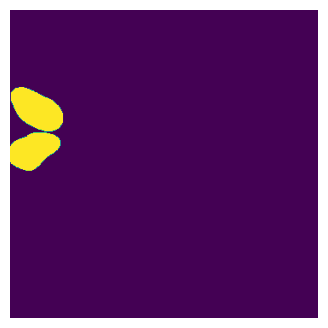

---
image no.  5
Area:  4007
predicted_iou:  0.9855438470840454
stability_score:  0.9344223737716675
-----------------------------------------------------------------


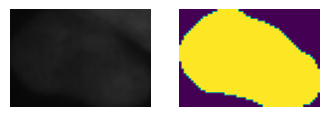

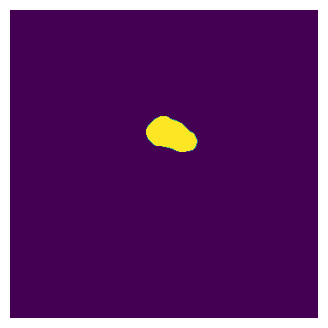

---
image no.  6
Area:  1726
predicted_iou:  0.9840512871742249
stability_score:  0.9765312075614929
-----------------------------------------------------------------


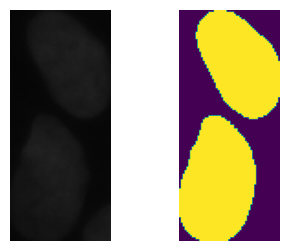

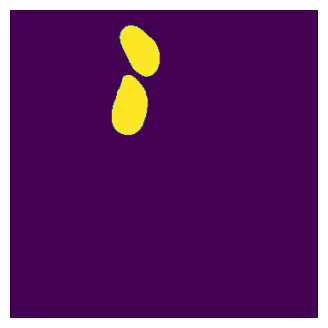

---
image no.  7
Area:  4128
predicted_iou:  0.9819691181182861
stability_score:  0.9791566729545593
-----------------------------------------------------------------


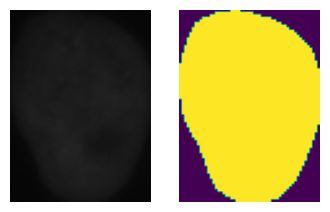

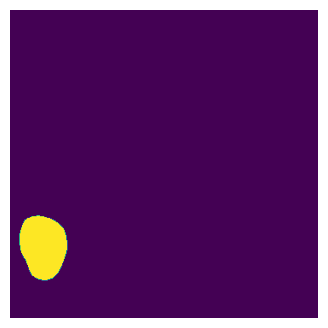

---
image no.  8
Area:  3270
predicted_iou:  1.0048447847366333
stability_score:  0.9878419637680054
-----------------------------------------------------------------


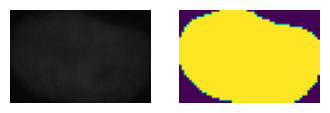

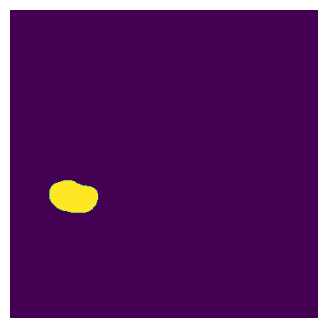

---
image no.  9
Area:  1707
predicted_iou:  1.0026721954345703
stability_score:  0.9912587404251099
-----------------------------------------------------------------
1 /content/kaggle-dsbowl-2018-dataset-fixes/stage1_train/b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38/images/b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38.png
No. of detected cells =  75


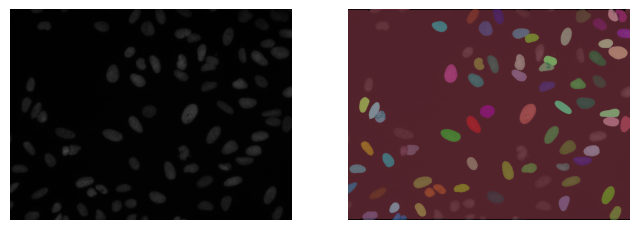

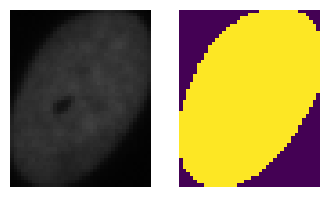

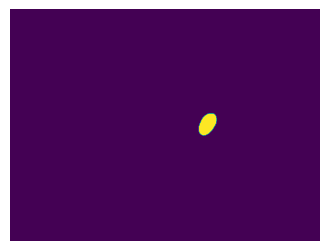

---
image no.  0
Area:  1422
predicted_iou:  1.0136191844940186
stability_score:  0.9929971694946289
-----------------------------------------------------------------


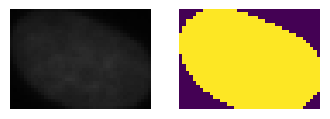

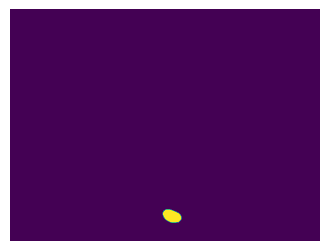

---
image no.  1
Area:  938
predicted_iou:  1.0076067447662354
stability_score:  0.992584764957428
-----------------------------------------------------------------


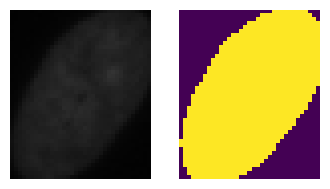

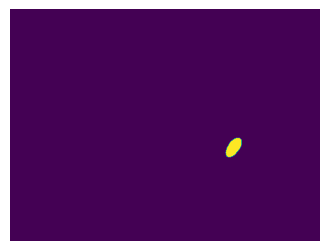

---
image no.  2
Area:  1023
predicted_iou:  1.0072749853134155
stability_score:  0.995121955871582
-----------------------------------------------------------------


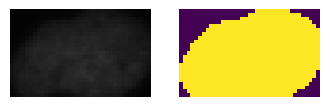

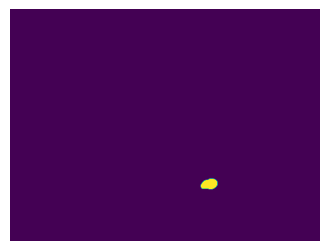

---
image no.  3
Area:  713
predicted_iou:  1.0043110847473145
stability_score:  0.9971949458122253
-----------------------------------------------------------------


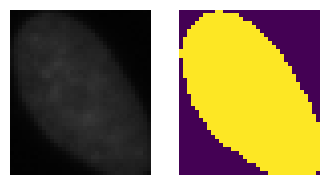

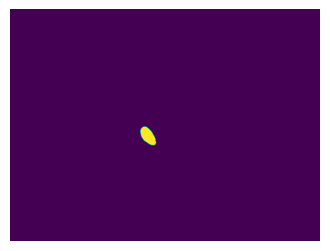

---
image no.  4
Area:  945
predicted_iou:  1.0041040182113647
stability_score:  0.9853095412254333
-----------------------------------------------------------------


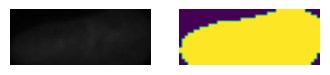

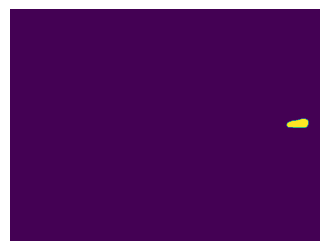

---
image no.  5
Area:  773
predicted_iou:  1.0036214590072632
stability_score:  0.9948387145996094
-----------------------------------------------------------------


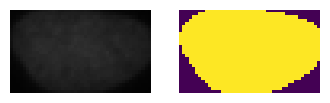

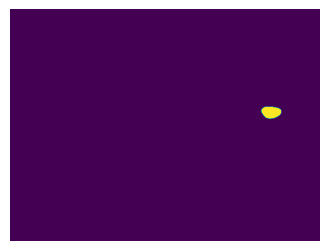

---
image no.  6
Area:  950
predicted_iou:  1.0030004978179932
stability_score:  0.9905660152435303
-----------------------------------------------------------------


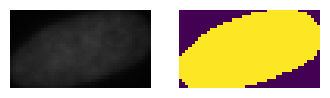

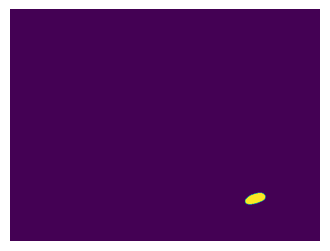

---
image no.  7
Area:  835
predicted_iou:  1.0016963481903076
stability_score:  0.9928486347198486
-----------------------------------------------------------------


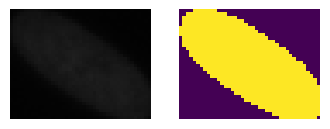

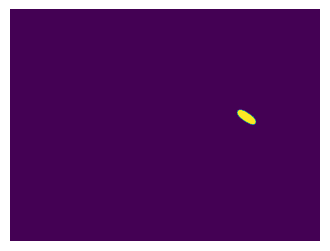

---
image no.  8
Area:  762
predicted_iou:  1.0013014078140259
stability_score:  0.9934725761413574
-----------------------------------------------------------------


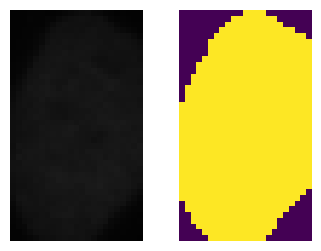

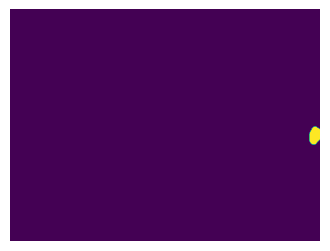

---
image no.  9
Area:  794
predicted_iou:  1.0010838508605957
stability_score:  0.9937106966972351
-----------------------------------------------------------------
2 /content/kaggle-dsbowl-2018-dataset-fixes/stage1_train/cfabf7379c5591d40aa4a20c86b4197c6a25ab55887a9fca4f06c2dfc0f0e973/images/cfabf7379c5591d40aa4a20c86b4197c6a25ab55887a9fca4f06c2dfc0f0e973.png
No. of detected cells =  26


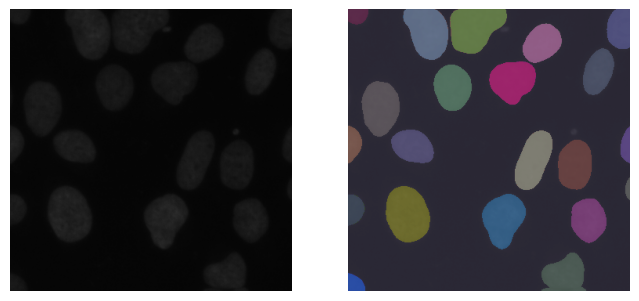

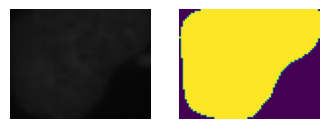

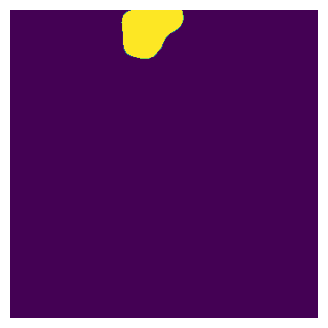

---
image no.  0
Area:  3079
predicted_iou:  1.009125828742981
stability_score:  0.9867784380912781
-----------------------------------------------------------------


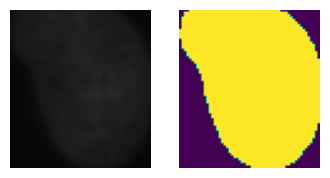

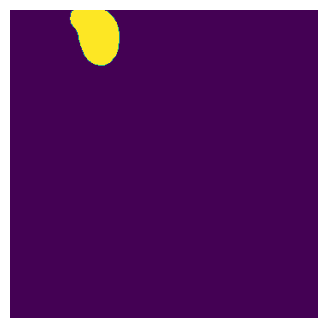

---
image no.  1
Area:  2808
predicted_iou:  1.0080426931381226
stability_score:  0.9820359349250793
-----------------------------------------------------------------


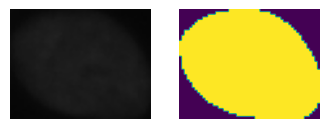

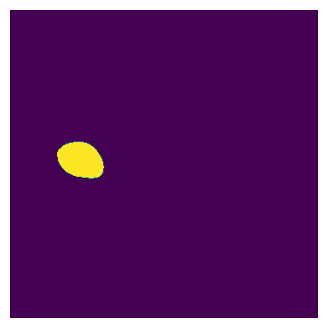

---
image no.  2
Area:  1799
predicted_iou:  0.9987325072288513
stability_score:  0.982910692691803
-----------------------------------------------------------------


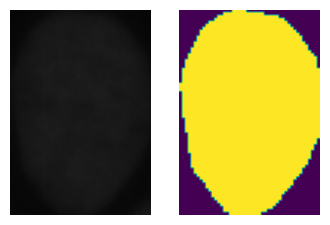

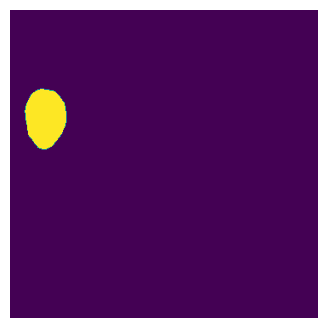

---
image no.  3
Area:  2643
predicted_iou:  0.9985908269882202
stability_score:  0.9831144213676453
-----------------------------------------------------------------


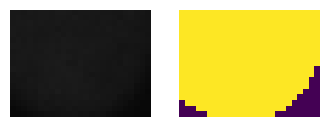

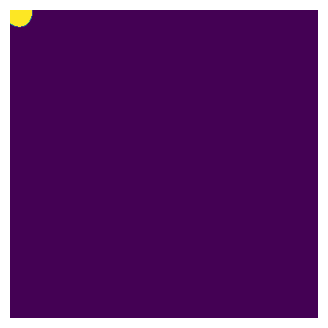

---
image no.  4
Area:  445
predicted_iou:  0.9973253607749939
stability_score:  0.9932735562324524
-----------------------------------------------------------------


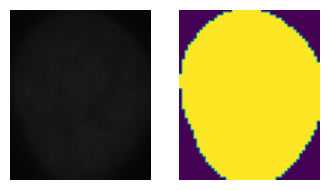

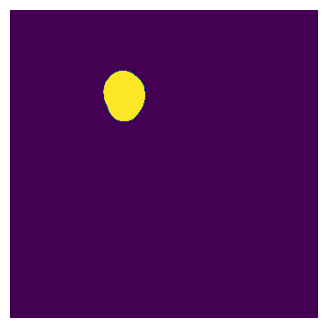

---
image no.  5
Area:  2234
predicted_iou:  0.9928346276283264
stability_score:  0.9875444769859314
-----------------------------------------------------------------


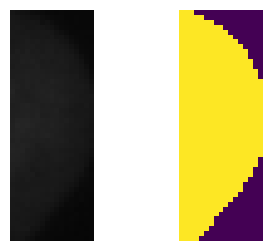

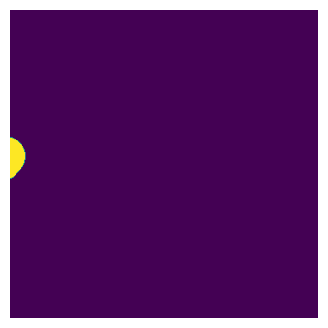

---
image no.  6
Area:  624
predicted_iou:  0.9893315434455872
stability_score:  0.9904610514640808
-----------------------------------------------------------------


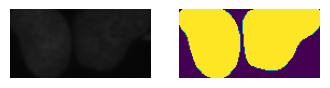

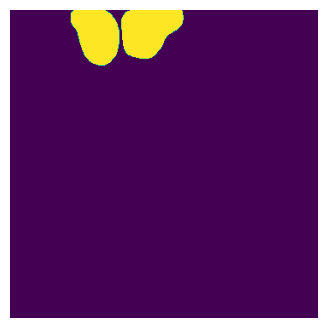

---
image no.  7
Area:  5926
predicted_iou:  0.987234354019165
stability_score:  0.9743973612785339
-----------------------------------------------------------------


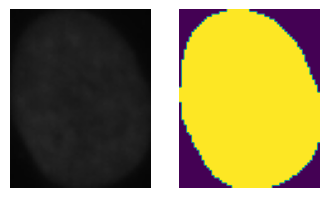

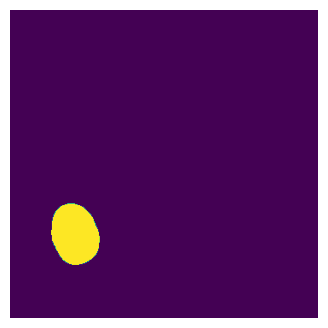

---
image no.  8
Area:  3162
predicted_iou:  1.0017341375350952
stability_score:  0.9861765503883362
-----------------------------------------------------------------


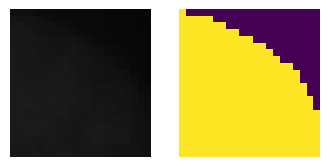

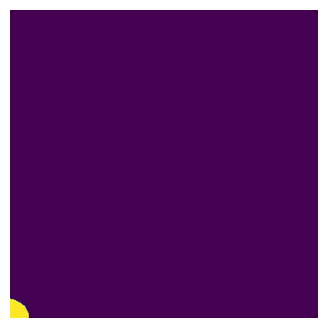

---
image no.  9
Area:  380
predicted_iou:  0.9929125905036926
stability_score:  0.9765625
-----------------------------------------------------------------
3 /content/kaggle-dsbowl-2018-dataset-fixes/stage1_train/2d53d7ec0c579fffd6710c956288537d46c719a93c6a04ac0d6550f75a6a6493/images/2d53d7ec0c579fffd6710c956288537d46c719a93c6a04ac0d6550f75a6a6493.png
No. of detected cells =  10


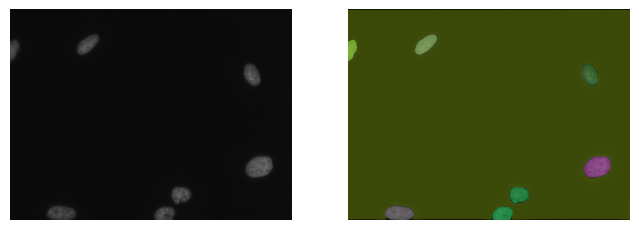

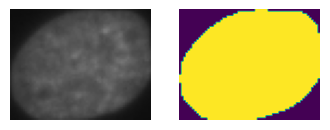

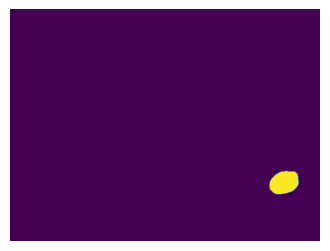

---
image no.  0
Area:  2708
predicted_iou:  1.0127902030944824
stability_score:  0.9930070042610168
-----------------------------------------------------------------


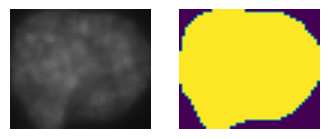

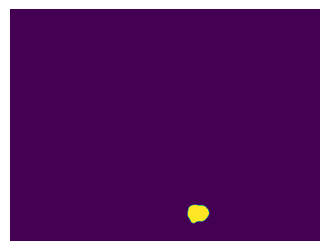

---
image no.  1
Area:  1537
predicted_iou:  1.0029999017715454
stability_score:  0.9902849793434143
-----------------------------------------------------------------


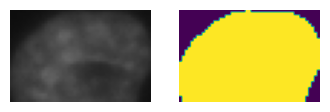

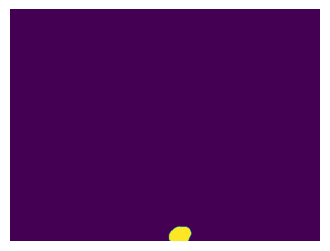

---
image no.  2
Area:  1371
predicted_iou:  0.991557240486145
stability_score:  0.9891383051872253
-----------------------------------------------------------------


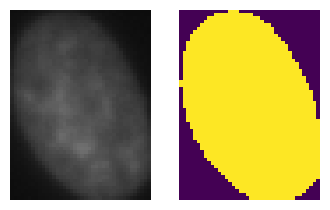

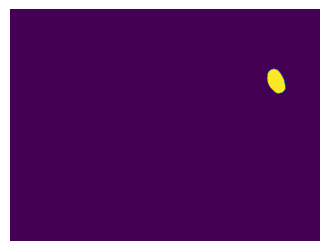

---
image no.  3
Area:  1618
predicted_iou:  1.0012081861495972
stability_score:  0.9907805919647217
-----------------------------------------------------------------


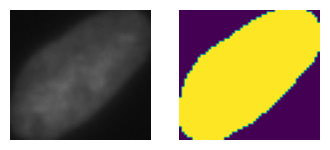

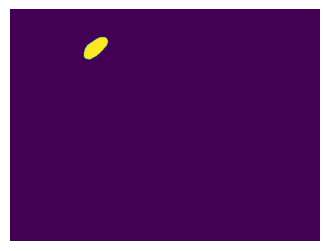

---
image no.  4
Area:  1653
predicted_iou:  0.9972034096717834
stability_score:  0.9921544790267944
-----------------------------------------------------------------


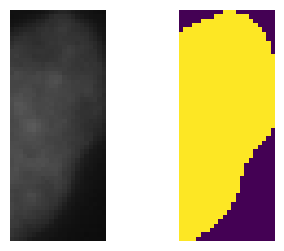

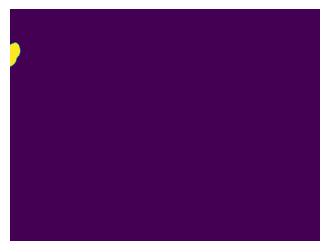

---
image no.  5
Area:  898
predicted_iou:  0.9965957403182983
stability_score:  0.9889135360717773
-----------------------------------------------------------------


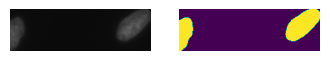

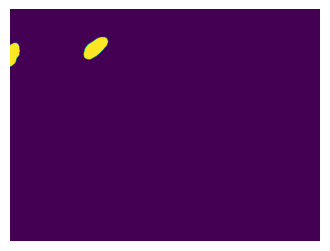

---
image no.  6
Area:  2524
predicted_iou:  0.9717699289321899
stability_score:  0.9784229397773743
-----------------------------------------------------------------


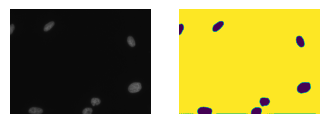

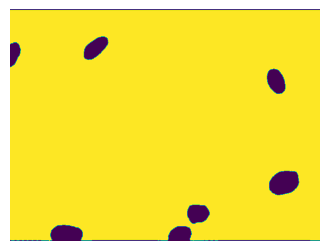

---
image no.  7
Area:  346913
predicted_iou:  1.0181151628494263
stability_score:  0.9943975210189819
-----------------------------------------------------------------


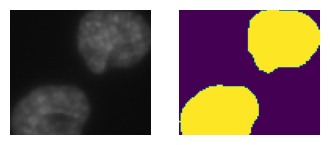

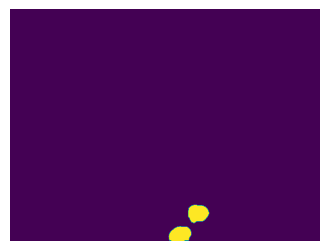

---
image no.  8
Area:  2859
predicted_iou:  0.9514573812484741
stability_score:  0.9560741186141968
-----------------------------------------------------------------


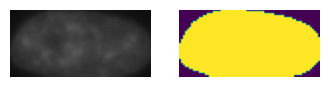

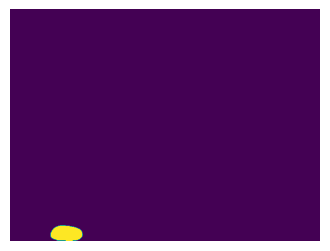

---
image no.  9
Area:  2047
predicted_iou:  1.0064400434494019
stability_score:  0.9830426573753357
-----------------------------------------------------------------


In [ ]:
from glob import glob
from PIL import Image, ImageOps
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

patch_paths = glob("/content/kaggle-dsbowl-2018-dataset-fixes/stage1_train/*/images/*")
print("No. of images = ",len(patch_paths))


for ii in range(4):
  image = cv2.imread(patch_paths[ii])
  masks = mask_generator.generate(image)
  print(ii, patch_paths[ii])
  print("No. of detected cells = ", len(masks))
  plt.figure(figsize=(8,5))
  plt.subplot(121)
  plt.imshow(image)
  plt.axis('off')
  plt.subplot(122)
  plt.imshow(image)
  show_anns(masks)
  plt.axis('off')
  plt.show()
#   for i in range(len(masks)):
  for i in range(10):
    x=int(masks[i]['bbox'][0])
    y=int(masks[i]['bbox'][1])
    a=int(masks[i]['bbox'][2])
    b=int(masks[i]['bbox'][3])
    cropped_im = image[y:y+b, x:x+a, :]
    cropped_mask = masks[i]['segmentation'][y:y+b, x:x+a]
    plt.figure(figsize=(4,3))
    plt.subplot(121)
    plt.imshow(cropped_im)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(cropped_mask)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(4,4))
    plt.imshow(masks[i]['segmentation'])
    plt.axis('off')
    plt.show()
    print("---")
    print("image no. ", str(i))
    print("Area: ", masks[i]['area'])
    print("predicted_iou: ", masks[i]['predicted_iou'])
    print("stability_score: ", masks[i]['stability_score'])
    print("-----------------------------------------------------------------")